1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

Poisson number of bins: 100


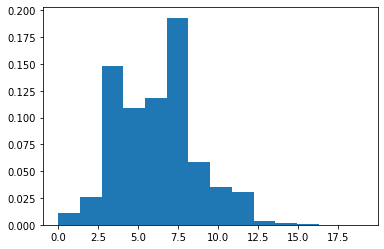

Z = 3.4661629670697414


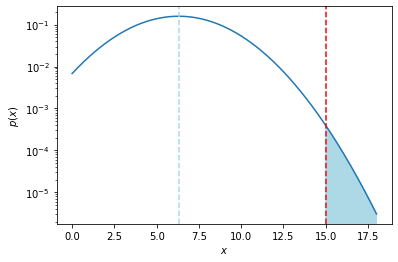

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi, erf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


mean = 6.3
variance = mean
s = np.random.poisson(mean, 10000)
pbins = int(np.sqrt(10000))
print("Poisson number of bins:", pbins)
count, bins, ignored = plt.hist(s, 14, density=True)
plt.show()

x0 = 15.
mu = mean
sigma = np.sqrt(mean)

# determine the Z score
Z = abs(x0 - mu) / sigma
print("Z =", Z)

# plot the measurement and its assumed pdf
w = np.abs(mu - x0)
x = np.linspace(0, w + mu + 3, 1000) 
y = stats.norm.pdf(x, loc=mu, scale=sigma)
plt.plot(x, y)
plt.fill_between(x, y, where=np.abs(x - mu) > w, color='lightblue')
plt.axvline(x0, linestyle='--', color='red')
plt.axvline(mu, linestyle='--', color='lightblue')
plt.ylabel("$p(x)$")
plt.xlabel("$x$")
plt.yscale("log")
plt.show()

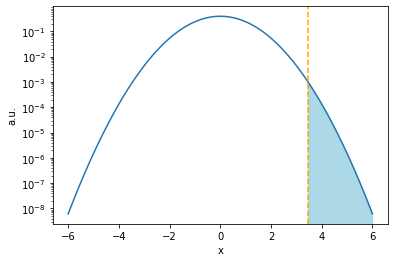

p-value = 0.00026397158691493505
alpha = 0.0013498980316301035


In [2]:
# plot the test statistics and its pdf
xs = np.linspace(-6, +6, 1000)
ts = stats.norm.pdf(xs)
plt.plot(xs, ts)
plt.fill_between(xs, ts, where=xs > Z, color='lightblue')
plt.axvline(Z, linestyle='--', color='orange')
plt.ylabel("a.u.")
plt.xlabel("x")
plt.yscale("log")
plt.show()

# consider only a tail
pvalue =  (1. - stats.norm.cdf(Z))
alpha = (1. - stats.norm.cdf(3))
print("p-value =", pvalue)
print("alpha =", alpha)

2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

T = -3.786997938137629


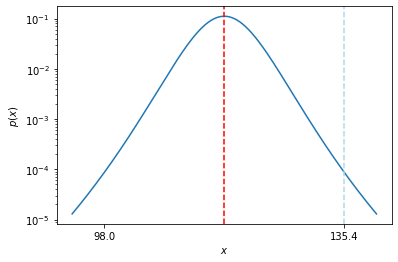

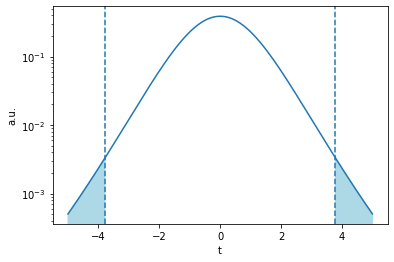

In [3]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])

mean1 = np.mean(pre)
mean2 = np.mean(post)


sigma = np.sqrt((np.var(pre, ddof=1)+np.var(post, ddof=1))/2) # calculate the variance and its sqrt()
n = len(pre) # the size of the data sample


# calculate the test statistics
T = (mean1 - mean2) / (sigma * np.sqrt(2/n) )
print("T =", T)

# plot the
mu = 1060. # the expected value for the mean
n = len(pre) # the size of the data sample
w = abs(mean1-mean2)

x = np.linspace(mean1 - w - 5, mean1 + w + 5, 1000)
y = stats.t.pdf(x, loc=mean1, scale=sigma / np.sqrt(len(pre)), df=len(pre) - 1)
plt.plot(x, y)
plt.axvline(mean1, linestyle='--', color='red')
plt.axvline(mean2, linestyle='--', color='lightblue')
plt.xticks([mean1 - w, mean1 + w], [mean1 - w, mean1 + w])
plt.ylabel("$p(x)$")
plt.xlabel("$x$")
plt.yscale("log")

plt.show()

xs = np.linspace(-5, +5, 1000)
ts = stats.t.pdf(xs, n - 1)
plt.plot(xs, ts)
plt.fill_between(xs, ts, where=np.abs(xs) > np.abs(T), color='lightblue')
plt.axvline(T, linestyle='--')
plt.axvline(-T, linestyle='--')
plt.ylabel("a.u.")
plt.xlabel("t")
plt.yscale("log")
plt.show()

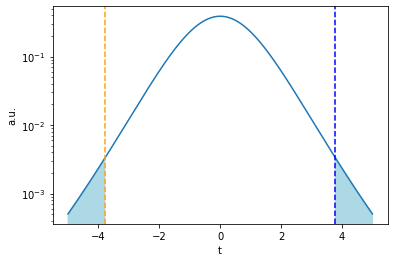

p-value = 0.004302464132864604
alpha = 0.025


In [4]:
# plot the test statistics and its pdf
xs = np.linspace(-5, +5, 1000)
ts = stats.t.pdf(xs, n - 1)
plt.plot(xs, ts)
plt.fill_between(xs, ts, where=np.abs(xs) > np.abs(T), color='lightblue')
plt.axvline(T, linestyle='--', color='orange')
plt.axvline(-T, linestyle='--', color='blue')
plt.ylabel("a.u.")
plt.xlabel("t")
plt.yscale("log")


plt.show()

# now we calculate the p-value. Since it's double sided:
pvalue = stats.t.cdf(T, n - 1) + (1. - stats.t.cdf(-T, n - 1))
print("p-value =", pvalue)
print("alpha =", 0.05/2,) 

- Determine whether the change in blood pressures within our sample was statistically significant.  

Since the p value is less than $p_{value}<\frac{\alpha}{2}$, we accept the null hypothesis. So the pressure decreases under halogen exposure.

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

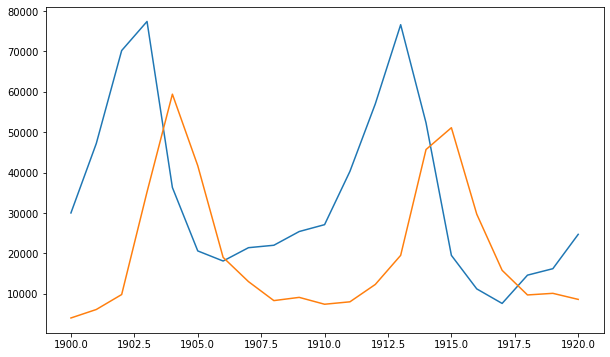

In [5]:
from scipy import fftpack

str = "populations.txt"
arr = np.loadtxt(str)

year, hares, lynxes, carrots = arr.T

fix, ax = plt.subplots(figsize = (10,6))
ax.plot(year,hares)
ax.plot(year,lynxes)
plt.show()

Hares Peak frequency: 0.09523809523809523
Lynxes Peak frequency: 0.09523809523809523


/home/ppprln96/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ppprln96/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[]

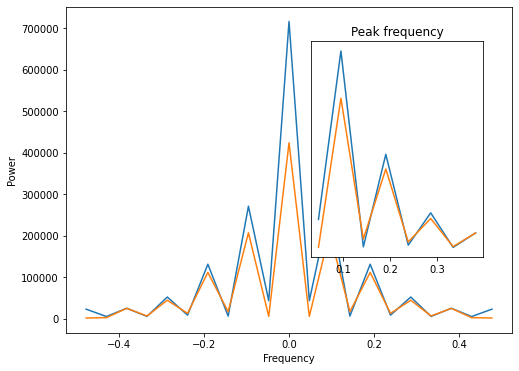

In [6]:
# The FFT of the signal
hsig_fft = fftpack.fft(hares)
lsig_fft = fftpack.fft(lynxes)

# And the power (sig_fft is of complex dtype)
hpower = np.abs(hsig_fft) # these are the "weights" of the Fourier components for each discrete frequency interval
lpower = np.abs(lsig_fft)

# The return the corresponding frequencies
hsample_freq = fftpack.fftfreq(hares.size, d=1)
lsample_freq = fftpack.fftfreq(lynxes.size, d=1)

# Plot the FFT power
plt.figure(figsize=(8, 6))
import seaborn as sns
sns.lineplot(hsample_freq, hpower)
sns.lineplot(lsample_freq, lpower)
plt.xlabel('Frequency')
plt.ylabel('Power')

# Find the peak frequency: focus only on only the positive frequencies
hpos_mask = np.where(hsample_freq > 0)
hfreqs = hsample_freq[hpos_mask]
hpowes = hpower[hpos_mask]
# find the max of freqs array
hpeak_freq = hfreqs[hpowes.argmax()]
print("Hares Peak frequency:", hpeak_freq)
lpos_mask = np.where(lsample_freq > 0)
lfreqs = lsample_freq[lpos_mask]
lpowes = lpower[lpos_mask]
# find the max of freqs array
lpeak_freq = lfreqs[hpowes.argmax()]
print("Lynxes Peak frequency:", lpeak_freq)


# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(hfreqs[:8], hpowes[:8])
plt.plot(lfreqs[:8], lpowes[:8])
plt.setp(axes, yticks=[])

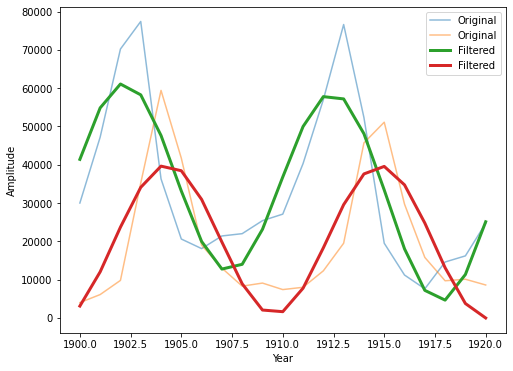

In [7]:
hhigh_freq_fft = hsig_fft.copy()
lhigh_freq_fft = lsig_fft.copy()
# filter (set to zero) all high frequency components that are larger than peak_freq
hhigh_freq_fft[np.abs(hsample_freq) > hpeak_freq] = 0
lhigh_freq_fft[np.abs(lsample_freq) > lpeak_freq] = 0
# calculate the Inverse Fast Fourier Transform
hfiltered_sig = fftpack.ifft(hhigh_freq_fft)
lfiltered_sig = fftpack.ifft(lhigh_freq_fft)
#take the real part
hreal_filtered_signal = np.real(hfiltered_sig)
lreal_filtered_signal = np.real(lfiltered_sig)

# plot the result of the IFFT
plt.figure(figsize=(8, 6))
plt.plot(year, hares, alpha=0.5, label='Original')
plt.plot(year, lynxes, alpha=0.5, label='Original')
plt.plot(year, hreal_filtered_signal, linewidth=3, label='Filtered')
plt.plot(year, lreal_filtered_signal, linewidth=3, label='Filtered')
plt.xlabel('Year')
plt.ylabel('Amplitude')
plt.legend(loc='best')

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

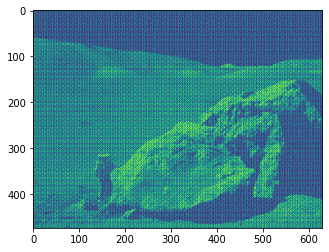

In [8]:
image = plt.imread('moonlanding.png')
plt.imshow(image)

Text(0.5, 1.0, 'Moonlanding')

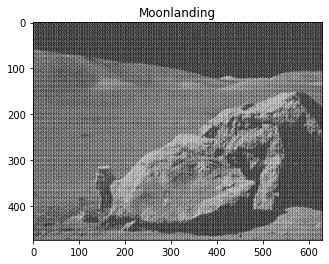

In [9]:
#load image 
plt.imshow(image,plt.cm.gray)
plt.title("Moonlanding")

Text(0.5, 1.0, 'Filtered')

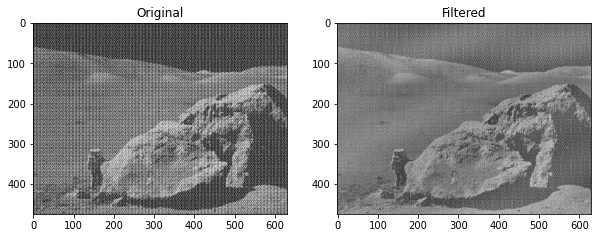

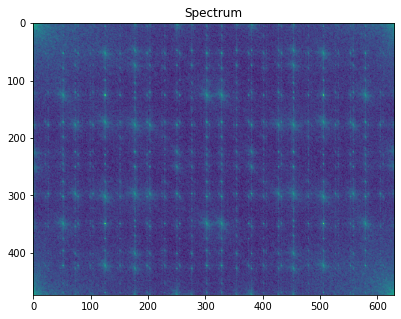

In [10]:
from matplotlib.colors import LogNorm

fig1, (image1, image2) = plt.subplots(1, 2, figsize=(10, 5))
image1.imshow(image, cmap = 'gray');
image1.set_title('Original')

# fft
image_fft = fftpack.fft2(image)

#power
power = np.abs(image_fft)

# noise to zero
filt_image = image_fft.copy()
filt_image[power>3000]=0

fig2, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.set_title('Spectrum')
ax.imshow(power, norm=LogNorm(vmin=5))

# IFT
filtered = np.real(fftpack.ifft2(filt_image))

image2.imshow(filtered, cmap = 'gray');
image2.set_title('Filtered')

Text(0.5, 1.0, 'Spectrum')

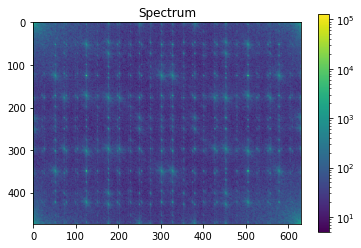

In [11]:
fft = fftpack.fft2(image)

plt.imshow(np.abs(fft), norm=LogNorm(vmin=5))
plt.colorbar()

plt.title('Spectrum')

Text(0.5, 1.0, 'Filtered Image')

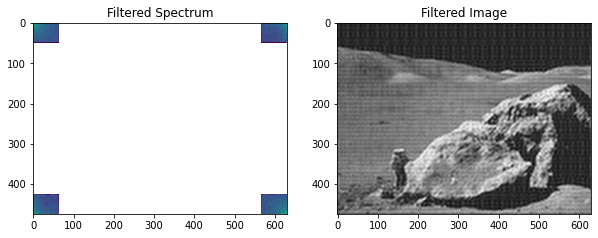

In [12]:
fig, (ax,ax1) = plt.subplots(1, 2, figsize=(10, 5))
# fraction of coefficients
fraction = 0.1
fft2 = fft.copy()

#row and columns
row, col = fft2.shape

# Set to zero 
fft2[int(row*fraction):int(row*(1-fraction))] = 0
fft2[:, int(col*fraction):int(col*(1-fraction))] = 0

ax.imshow(np.abs(fft2), norm=LogNorm(vmin=5))
ax.set_title('Filtered Spectrum')

filtred = fftpack.ifft2(fft2).real

ax1.imshow(filtred, plt.cm.gray)
ax1.set_title('Filtered Image')

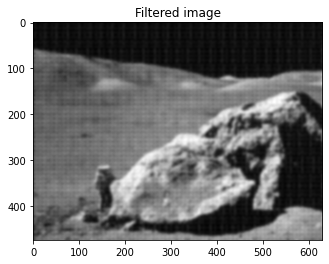

In [13]:
#Multidimensional Gaussian filter.
from scipy import ndimage

im = ndimage.gaussian_filter(image, 3)

plt.imshow(im, plt.cm.gray)
plt.title('Filtered image')

plt.show()